In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/star-type-classification/Stars.csv


<h3>Importing Dependencies</h3>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, auc, roc_curve

<h3>Reading Data and General Analysis</h3>

In [4]:
data = pd.read_csv("/kaggle/input/star-type-classification/Stars.csv")
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


**Checking for Missing values**

In [6]:
data.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

- There are no missing values

**Statistical Summary**

In [7]:
data.iloc[:,0:4].describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
L,240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
R,240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
A_M,240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06


- There is high degree of variation in the first and second quartile of A_M. The data seems to be left skewed.
- The mean for R >> median. The differece between max and 75% is high. So is the difference between 50% and 75%. The variance is also very high. There might be a tail towards the right.
- The same is true for L as well. There is a log tail to the right.
- The variance in temprature is relatively less. But it is also skewed to the right.

**Degree of Skewness in the Numerical Variables**

In [8]:
for col in data.iloc[:,0:4].columns:
    print(col,"-->",st.skew(data[col]))

Temperature --> 1.3132941596030199
L --> 2.0551209435208415
R --> 1.9346117254577848
A_M --> -0.1207786427322443


<h2>Univariate Analysis</h2>

<h3>Visualizing the Target Variable</h3>

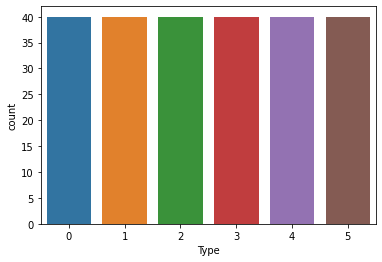

In [9]:
sns.countplot(data.Type);

The data seems to be absolutely balanced

<h3>Analyzing the distribution of Color</h3>

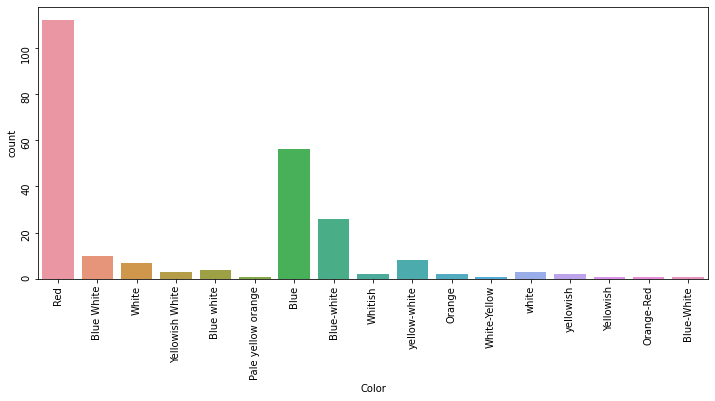

In [10]:
f,ax = plt.subplots(figsize=(12,5))
sns.countplot(data.Color,ax=ax);
ax.tick_params(labelrotation=90)

- Most of the stars are red

In [11]:
pd.value_counts(data.Color)

Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
yellowish               2
Orange                  2
Whitish                 2
Orange-Red              1
White-Yellow            1
Yellowish               1
Blue-White              1
Pale yellow orange      1
Name: Color, dtype: int64

<h3>Spectral Class</h3>

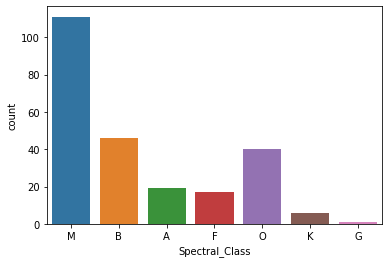

In [12]:
sns.countplot(data.Spectral_Class);

In [13]:
pd.value_counts(data.Spectral_Class)

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64

In [14]:
def univariate(x, color='b', transformed=None):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
    ax[0,0].set_title(label=f"Distribution of {x.name}")
    sns.distplot(x, ax=ax[0,0], color=color);
    ax[0,1].set_title(label=f"QQ plot for {x.name}")
    st.probplot(x, plot=ax[0,1]);
    sns.boxplot(x, ax=ax[1,0], color=color);
    ax[1,1].set_title(label=f"CDF for {x.name}")
    sns.kdeplot(x, cumulative=True, ax=ax[1,1], color=color)
    f.suptitle(t=f"Univariate Analysis for {x.name}",fontsize=16) if not transformed else f.suptitle(t=f"{transformed} Transformed {x.name}",fontsize=16)
    f.tight_layout();

<h3>Temperature</h3>

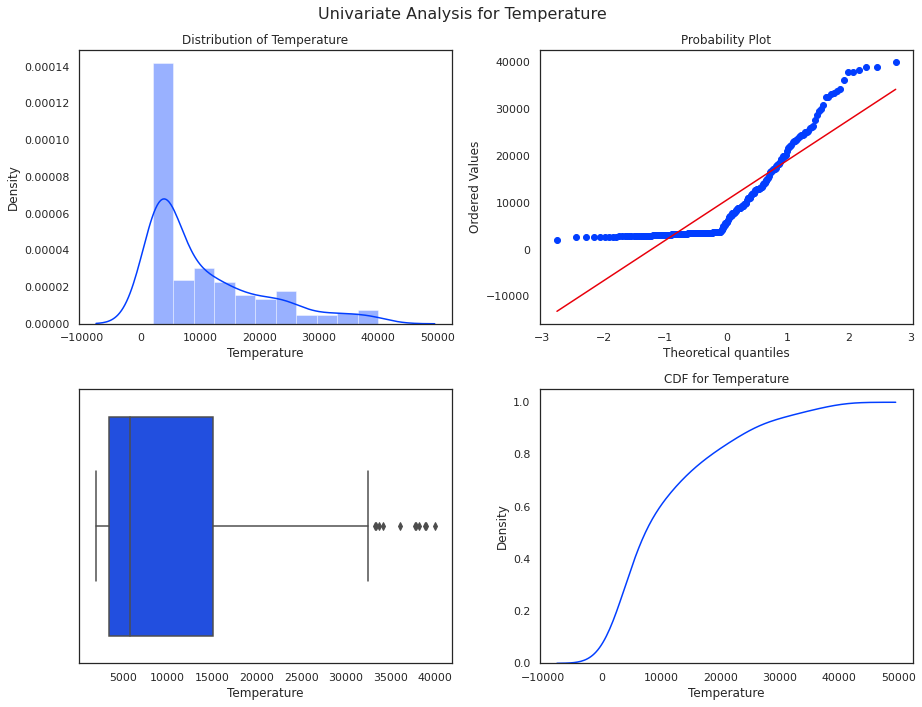

In [15]:
sns.set(style='white', palette='bright', color_codes=True)
univariate(data.Temperature)

- Most of the data peaks around 2000.
- More than 50% of the values are a little over 10000.
- About 80% of the data is around 20000.
- More than 90% are less than 35000.

In [16]:
sns.set(style='dark', palette='colorblind', color_codes=True)

**Using Power Transforms to eliminate outliers**

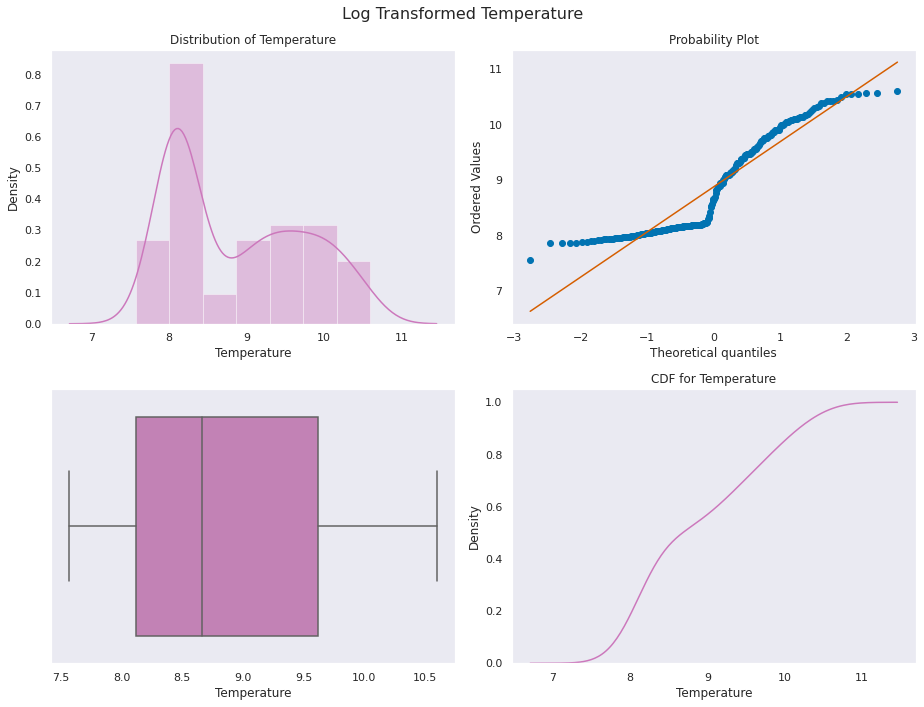

In [17]:
log_transformer = FunctionTransformer(func=np.log1p)
log_temp = log_transformer.fit_transform(data.Temperature)
univariate(log_temp, color='m',transformed='Log')

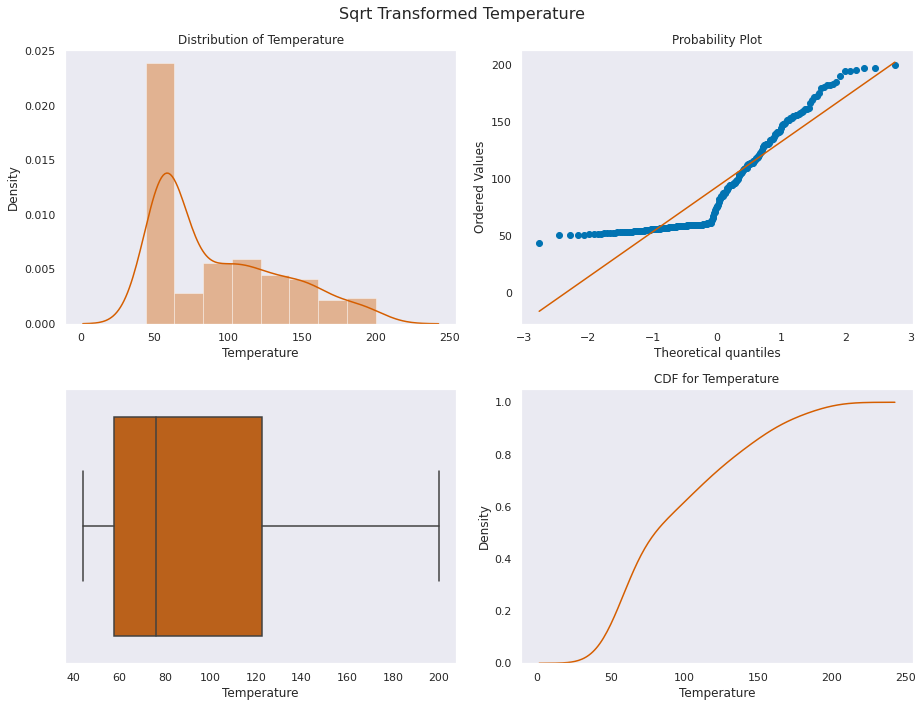

In [18]:
sqrt_transformer = FunctionTransformer(func=np.sqrt)
sqrt_temp = sqrt_transformer.fit_transform(data.Temperature)
univariate(sqrt_temp, color='r',transformed='Sqrt')

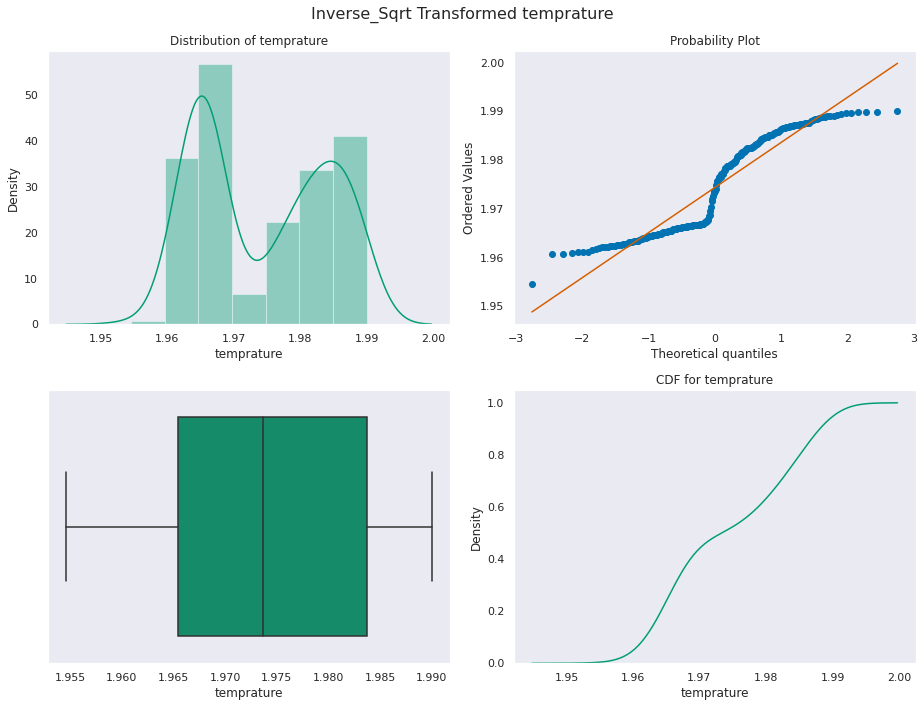

In [19]:
univariate(
    pd.Series(
        st.boxcox(data.Temperature, lmbda=-0.5),
        name="temprature"),
    color='g',transformed='Inverse_Sqrt')

<h3>A_M</h3>

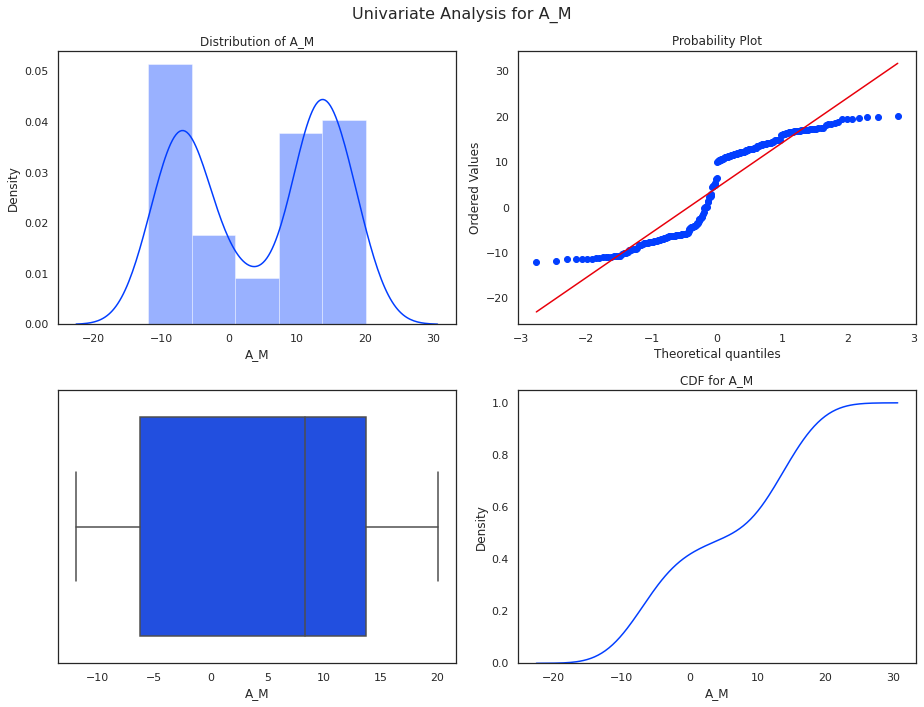

In [20]:
sns.set(style='white', palette='bright', color_codes=True)
univariate(data.A_M)

- There are no outliers here.
- The distribution is bimodal.
- Close to 50% of the data is 0 or less. The rest of the data is more than 0.

<h3>L</h3>

In [21]:
sns.set(style='white', palette='bright', color_codes=True)

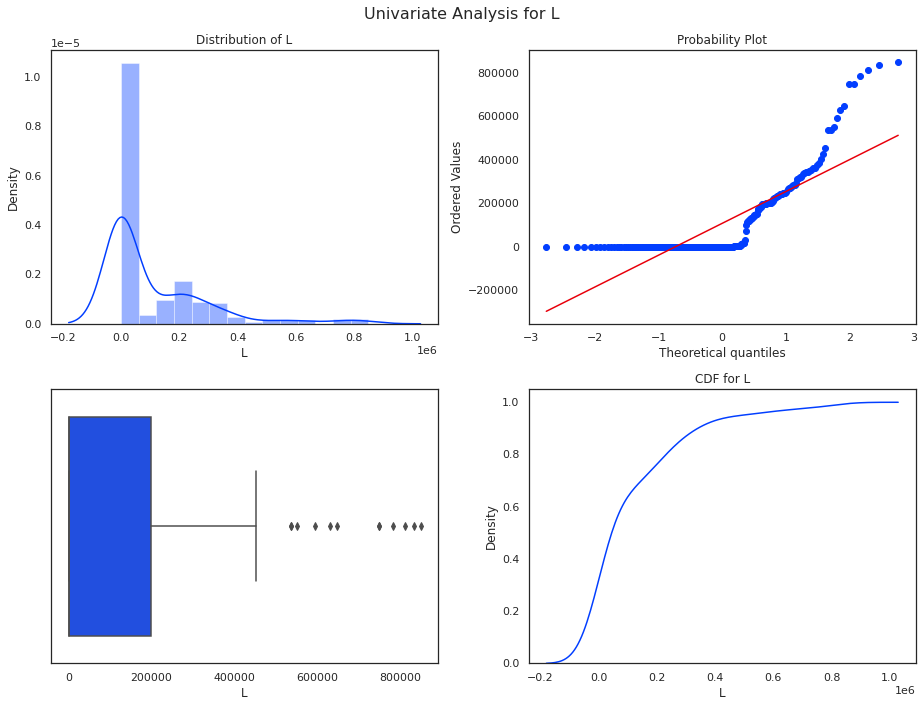

In [22]:
univariate(data.L)

In [23]:
# rs = RobustScaler()
# failed to remove outliers and normalize
# robustly_scaled_l = pd.Series(rs.fit_transform(data.L.to_numpy().reshape(-1,1)).squeeze(), name='robustly_scaled_l')
%reset_selective -f '^robustly_scaled_l$'

**Using Log Transform to transform outliers**

In [24]:
# removed the outliers but data remains bimodal.
log_L = pd.Series(log_transformer.fit_transform(data.L.to_numpy().reshape(-1,1)).squeeze(), name='log_L')

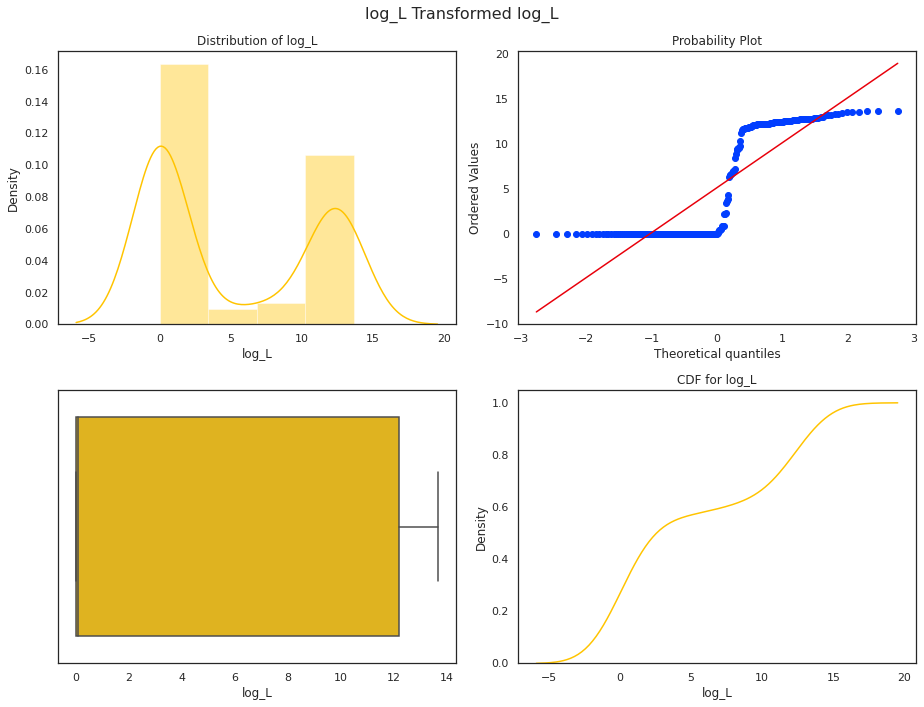

In [25]:
univariate(
    log_L,
    color='y',
    transformed="log_L")

- After transforming the L data using robust scaler, more than 95% seems to have a value less than 3.
- 90% have a value less than or equal to 2.
- 70% have a value less than 1.
- close to 30% have a value less than or equal to 0.

<h3>R</h3>

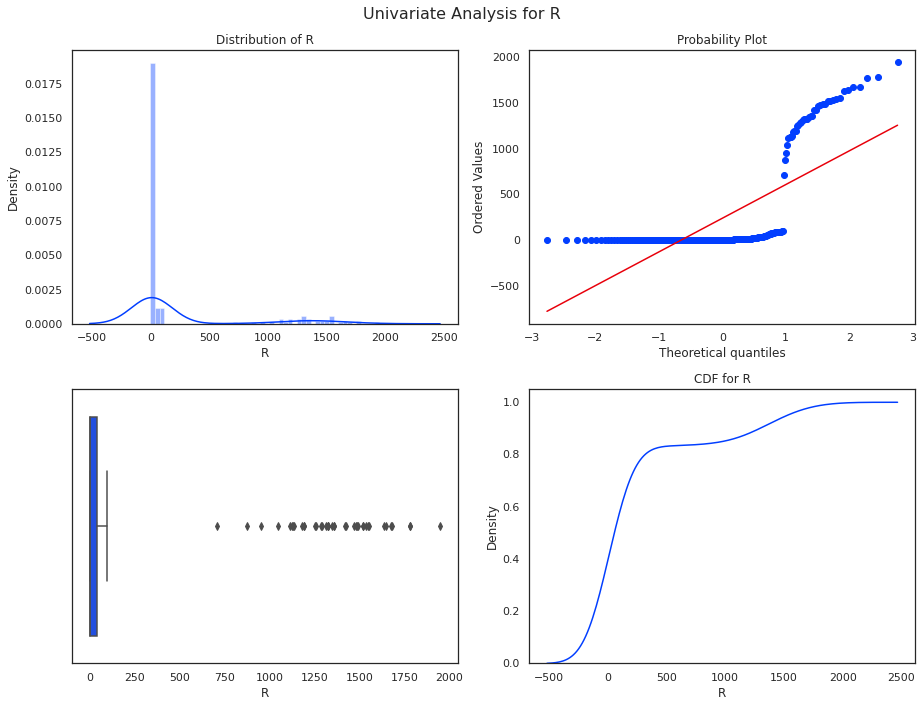

In [26]:
univariate(data.R)

**Using Log transform to transform outliers**

In [27]:
# outliers are eliminated
log_R = pd.Series(log_transformer.fit_transform(data.R.to_numpy().reshape(-1,1)).squeeze(), name='log_R')

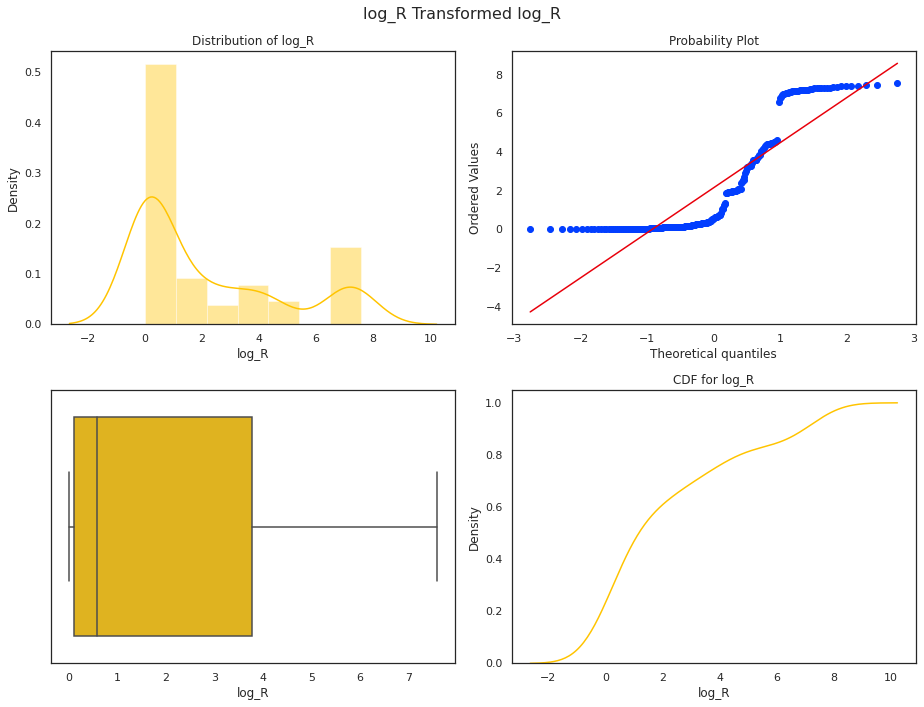

In [28]:
univariate(
    log_R,
    color='y',
    transformed="log_R")

**Attaching the transformed columns to the dataset**

In [29]:
data['sqrt_temp'] = sqrt_temp
data['log_L'] = log_L
data['log_R'] = log_R

**Creating one-hot encodeded variables for the categorical columns**

In [30]:
Spectral_Class = pd.get_dummies(data.Spectral_Class, drop_first=True, prefix='Spectral_Class_')
Color = pd.get_dummies(data.Color, drop_first=True, prefix='Color_')

**Standardizing the data**

In [31]:
scaler= StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(data.loc[:,['sqrt_temp', 'A_M', 'log_L', 'log_R']]), columns=['sqrt_temp', 'A_M', 'log_L', 'log_R'])

<h3>Pairplot and Correlation Analysis</h3>

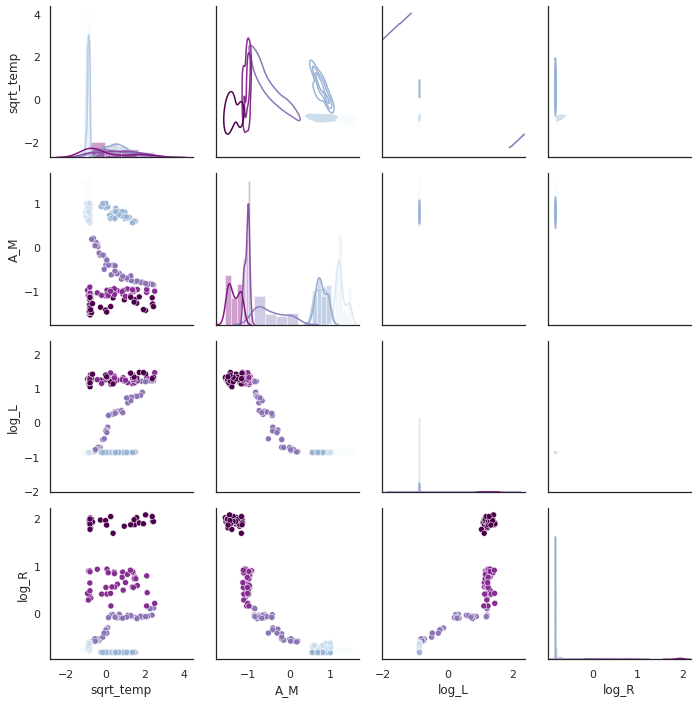

In [32]:
temp=scaled.loc[:]
temp['Type']=data['Type']
g = sns.PairGrid(temp, diag_sharey=False, hue='Type', palette='BuPu')
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_upper(sns.kdeplot);

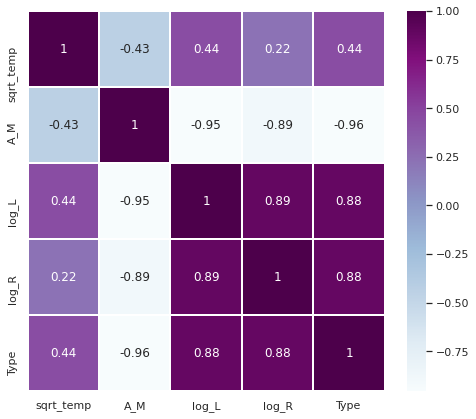

In [33]:
f, ax = plt.subplots(figsize=(8,7))
corr_df = temp.corr()
sns.heatmap(corr_df, annot=True, cmap='BuPu', linewidths=0.2);

- There is an extrem degree of multicolinearity

In [34]:
transformed = pd.concat([scaled, Spectral_Class, Color], axis=1).reset_index(drop=True)
transformed.shape

(240, 26)

<h3>Dimensionality Reduction using PCA to Remove Noise</h3>

In [35]:
pca = PCA(n_components=26, random_state=123)
pca.fit(transformed)

PCA(n_components=26, random_state=123)

In [36]:
pca.explained_variance_

array([3.16561819e+00, 1.20186018e+00, 1.98812099e-01, 1.79742832e-01,
       1.05617718e-01, 6.74472973e-02, 5.56759200e-02, 3.54543848e-02,
       3.01203990e-02, 2.64925156e-02, 2.27553158e-02, 1.67979350e-02,
       1.45250201e-02, 1.27217484e-02, 1.08105755e-02, 8.33037979e-03,
       6.76925297e-03, 6.36264962e-03, 5.84345844e-03, 4.57016879e-03,
       4.18407899e-03, 4.18356231e-03, 3.21060940e-03, 2.15253726e-03,
       8.93052228e-04, 1.17372539e-32])

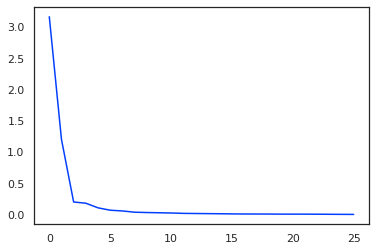

In [37]:
sns.lineplot(x=range(26), y=pca.explained_variance_);

In [38]:
pca.explained_variance_ratio_

array([6.09833854e-01, 2.31529825e-01, 3.82997385e-02, 3.46261796e-02,
       2.03465029e-02, 1.29932426e-02, 1.07255704e-02, 6.83003533e-03,
       5.80248087e-03, 5.10359491e-03, 4.38364992e-03, 3.23600283e-03,
       2.79814193e-03, 2.45075444e-03, 2.08258057e-03, 1.60478848e-03,
       1.30404849e-03, 1.22571924e-03, 1.12570075e-03, 8.80410548e-04,
       8.06033091e-04, 8.05933557e-04, 6.18501090e-04, 4.14671010e-04,
       1.72040167e-04, 2.26109857e-33])

In [39]:
pca.explained_variance_ratio_[:3].sum()

0.8796634172194759

**The first 3 components put together explain 87% of the variation in the data**

In [40]:
pca = PCA(n_components=3,random_state=123)
pca.fit(transformed)
reduced_data = pca.transform(transformed)

**Visualizing the reduced dataset**

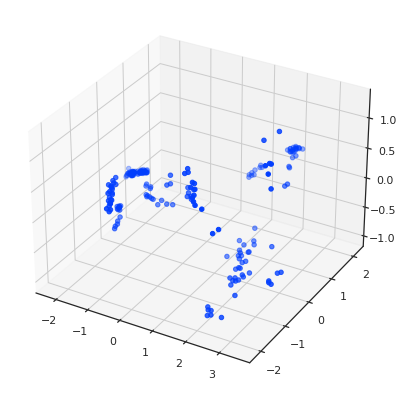

In [41]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(reduced_data[:,0],reduced_data[:,1],reduced_data[:,2])

<h2>Data Preparation</h2>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data, data['Type'], test_size=0.3, random_state=123)

<h2>Model building</h2>

In [43]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [44]:
y_pred_proba = lda_clf.predict_proba(X_test)
y_pred = lda_clf.predict(X_test)
print('Training_score:', lda_clf.score(X_train, y_train))
print("Tet_score:", lda_clf.score(X_test, y_test))

Training_score: 0.9166666666666666
Tet_score: 0.9444444444444444


In [45]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,1.0,0.769231,1.0,1.000000,0.909091,1.0,0.944444,0.946387,0.955322
recall,1.0,1.000000,1.0,0.636364,1.000000,1.0,0.944444,0.939394,0.944444
f1-score,1.0,0.869565,1.0,0.777778,0.952381,1.0,0.944444,0.933287,0.941320
support,13.0,10.000000,17.0,11.000000,10.000000,11.0,0.944444,72.000000,72.000000


- LDA gives us an accuracy of 94%
<hr>